# <span style="color:#1f4e79"> Nonlinear Time Series: OLS and NLS</span>
- RIEF - Winter School 2025 
- Prepared by: Cesar Ramos

En este notebook, evaluamos ambos metodos OLS cuando el modelo es lineal en parámetros y los supuestos lo permiten; usamos NLS cuando la función de media depende no linealmente de los parámetros.

## Contenido
- Simulación de datos con una media exponencial $y_t=\alpha e^{\beta x_t}+\varepsilon_t$ (error aditivo).
- OLS lineal mal especificado: $y_t=b_0+b_1 x_t+u_t$.
- Log-OLS (solo como semilla o si el error fuera multiplicativo).
- NLS (Gauss–Newton/LM) estimando $\theta=(\alpha,\beta)$.
- Errores estándar (homocedásticos y robustos White/HAC).
- Comparación con RMSE/AIC/BIC en train/test.
- Diagnóstico (residuales vs ajustados) y mensajes pedagógicos sobre cuándo elegir OLS o NLS en series de tiempo.

In [9]:
import numpy as np
import pandas as pd
from numpy.linalg import inv, lstsq, solve, norm
import matplotlib.pyplot as plt
rng = np.random.default_rng(2025)

### Introducción y DGP

#### Exponential mean vs Linear OLS: cuándo usar NLS en series de tiempo

**Objetivo.** Estudiar un DGP no lineal en la media y comparar OLS (lineal en parámetros) versus NLS (no lineal en parámetros) en términos de estimación e inferencia.

#### Data-Generating Process (DGP)

Asumimos la **forma funcional poblacional**:
$$
y_t \;=\; \alpha\, e^{\beta x_t} \;+\; \varepsilon_t,\qquad \mathbb{E}[\varepsilon_t\mid \mathcal{F}_{t-1}]=0,\ \ \operatorname{Var}(\varepsilon_t\mid \mathcal{F}_{t-1})=\sigma^2,
$$
donde $x_t$ puede ser exógeno (o un proceso estacionario) y $\varepsilon_t$ es un shock aditivo.

**Mensaje clave.** Con **error aditivo**, la log-transformación **no** linealiza sin sesgo; se requiere **NLS en la escala original**. La log-linearización sí es válida si el error es **multiplicativo** (ver más abajo).


In [15]:
# 1) Simulate data
# Simulación: y_t = alpha * exp(beta * x_t) + eps_t  (error ADITIVO)
# Nota: Si los shocks fueran multiplicativos (y_t = alpha * exp(beta x_t) * eta_t),
# la regresión válida sería sobre log(y_t). Aquí NO lo es: usamos NLS en y.

n = 1000
x = np.linspace(0, 5, n)
alpha_true, beta_true = 2.0, 0.35
sigma = 0.30
y_true = alpha_true * np.exp(beta_true * x)
y = y_true + rng.normal(0, sigma, size=n)

data = pd.DataFrame({"x": x, "y": y, "y_true": y_true})

In [11]:
data.head(20).round(2)

,x,y,y_true
0,0.00,1.33,2.00
1,0.00,2.01,2.00
2,0.00,1.84,2.00
3,0.00,1.66,2.00
4,0.00,1.27,2.00
5,0.00,2.23,2.00
6,0.00,1.77,2.00
7,0.00,2.08,2.00
8,0.00,2.21,2.00
9,0.00,2.09,2.00


In [16]:
# Train/test split
split = int(0.7 * n)
train, test = data.iloc[:split].copy(), data.iloc[split:].copy()
train.shape, test.shape

((700, 3), (300, 3))

In [17]:
train.head()

,x,y,y_true
0,0.000000,1.304394,2.000000
1,0.005005,2.329470,2.003507
2,0.010010,1.972756,2.007019
3,0.015015,2.205727,2.010538
4,0.020020,1.606808,2.014063


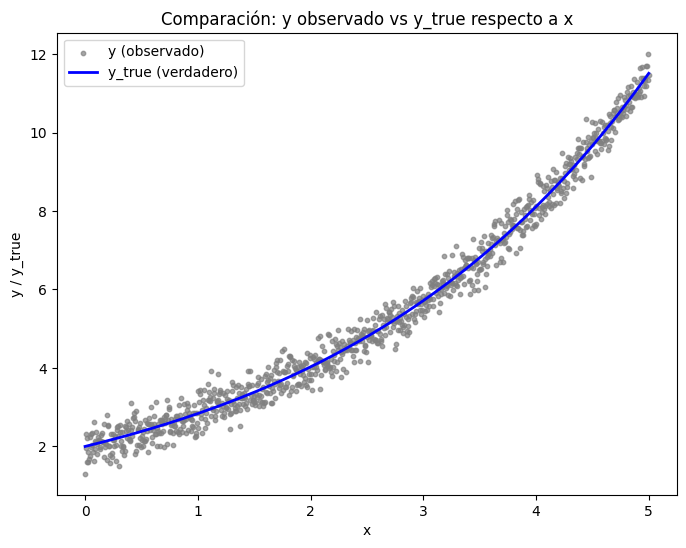

In [18]:
# Plot: y y y_true vs x 
plt.figure(figsize=(8,6))
plt.scatter(data["x"], data["y"], label="y (observado)", color="gray", s=10, alpha=0.7)
plt.plot(data["x"], data["y_true"], label="y_true (verdadero)", color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("y / y_true")
plt.title("Comparación: y observado vs y_true respecto a x")
plt.legend()
plt.show()

### OLS: estimación e inferencia (especificado erronea)

#### OLS lineal (modelo mal especificado para un DGP exponencial)

**Modelo estimado (lineal en parámetros):**
$$
y_t \;=\; b_0 + b_1 x_t + u_t,\qquad \widehat{\beta}_{\text{OLS}} = (X'X)^{-1}X'y,
$$
con $X=[\mathbf{1},\, x]$.

**Varianzas:**
- Homocedástico: $$\widehat{\mathrm{Var}}(\widehat{\beta})=\hat\sigma^2 (X'X)^{-1},\quad \hat\sigma^2=\frac{\sum_t \hat u_t^2}{T-p}.$$
- Robusto White/HAC (series de tiempo):  
$$
\widehat{\mathrm{Var}}_{\text{HAC}}(\widehat{\beta})=(X'X)^{-1}
\left(\sum_{h=-L}^{L}k(h,L)\,\Gamma_h\right)(X'X)^{-1},
\quad \Gamma_h=\sum_t \hat u_t \hat u_{t-h} X_t X_{t-h}'.
$$

**Advertencia.** Como la media verdadera es exponencial, OLS está **mal especificado** globalmente. Puede aproximar en rangos pequeños de $x_t$, pero generará **curvatura residual** y posible **heterocedasticidad**.


In [19]:
# OLS lineal: y_t ~ 1 + x_t  (modelo mal especificado)
# Recomendación en series de tiempo: siempre reportar SE robustos (HAC/Newey-West)
# para evitar inferencia optimista por autocorrelación/heterocedasticidad.

# 2) OLS: y = b0 + b1 x + u
def fit_ols(df):
    X = np.column_stack((np.ones(len(df)), df["x"].to_numpy()))
    yv = df["y"].to_numpy()
    beta_hat = lstsq(X, yv, rcond=None)[0]
    resid = yv - X @ beta_hat
    n, p = X.shape
    s2 = (resid @ resid) / (n - p)
    cov_homo = s2 * inv(X.T @ X)
    S = (X * resid[:, None]).T @ (X)  # X' diag(e^2) X
    cov_white = inv(X.T @ X) @ S @ inv(X.T @ X)
    return {"beta": beta_hat, "resid": resid, "X": X, "sigma2": s2,
            "cov_homo": cov_homo, "cov_white": cov_white, "fitted": X @ beta_hat}

ols_tr = fit_ols(train)
ols_te_pred = np.column_stack((np.ones(len(test)), test["x"].to_numpy())) @ ols_tr["beta"]

## Log-OLS: cuándo sí y cómo retransformar

## ¿Puedo log-linearizar? Solo si el error es multiplicativo

Si el DGP fuera $y_t=\alpha e^{\beta x_t}\cdot \eta_t$ con $\mathbb{E}[\eta_t\mid \mathcal{F}_{t-1}]=1$ y $\eta_t>0$:
$$
\ln y_t = \ln\alpha + \beta x_t + \varepsilon_{\log,t},\qquad \mathbb{E}[\varepsilon_{\log,t}\mid \mathcal{F}_{t-1}]=0.
$$

**Retransformación a $y$:**
- Si $\varepsilon_{\log,t}\sim \mathcal{N}(0,\sigma^2)$,
$$
\widehat{y}_t = \exp\!\big(\widehat{\ln\alpha}+\widehat\beta x_t + \widehat{\sigma}^2/2\big).
$$
- **Smearing de Duan (1983)** (no requiere normalidad):
$$
\widehat{y}_t = \exp(\widehat{m}(x_t)) \cdot \left(\frac{1}{T}\sum_{i=1}^{T}\exp(\widehat{\varepsilon}_{\log,i})\right).
$$

**En este cuaderno** el error es **aditivo**, por lo que el log solo sirve como **semilla numérica** para NLS.


In [69]:
# 3) NLS: y = alpha * exp(beta x) + e  (Gauss–Newton)
def nls_gauss_newton(df, theta0=None, max_iter=50, tol=1e-10):
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()
    n = len(y)
    if theta0 is None:
        mask = y > 0
        X0 = np.column_stack((np.ones(mask.sum()), x[mask]))
        bb = lstsq(X0, np.log(y[mask]), rcond=None)[0]
        theta = np.array([np.exp(bb[0]), bb[1]])
    else:
        theta = np.array(theta0, dtype=float)
    history = []
    for it in range(max_iter):
        a, b = theta
        e = np.exp(b * x)
        f = a * e
        r = y - f
        J = np.column_stack((e, a * x * e))
        A = J.T @ J
        g = J.T @ r
        try:
            delta = solve(A, g)
        except np.linalg.LinAlgError:
            delta = lstsq(A, g, rcond=None)[0]
        theta_new = theta + delta
        history.append({"iter": it, "alpha": a, "beta": b, "RSS": float(r.T @ r), "step_norm": norm(delta)})
        if norm(delta) < tol:
            theta = theta_new
            break
        theta = theta_new
    a, b = theta
    e = np.exp(b * x)
    f = a * e
    r = y - f
    J = np.column_stack((e, a * x * e))
    p = 2
    sigma2 = (r @ r) / (n - p)
    cov_homo = sigma2 * inv(J.T @ J)
    cov_white = inv(J.T @ J) @ (J.T @ (J * (r[:, None]**2)) ) @ inv(J.T @ J)
    return {"theta": theta, "resid": r, "J": J, "sigma2": sigma2,
            "cov_homo": cov_homo, "cov_white": cov_white, "fitted": f,
            "history": pd.DataFrame(history)}

nls_tr = nls_gauss_newton(train)
def nls_predict(x, theta):
    return theta[0] * np.exp(theta[1] * x)
nls_te_pred = nls_predict(test["x"].to_numpy(), nls_tr["theta"])

In [70]:
# 4) Metrics
def metrics(df, fitted, params, cov_homo, name):
    y = df["y"].to_numpy()
    resid = y - fitted
    n = len(y); k = len(params)
    sse = resid @ resid
    sst = ((y - y.mean()) @ (y - y.mean()))
    r2 = 1 - sse/sst
    rmse = np.sqrt(sse / n)
    aic = n * np.log(sse / n) + 2 * k
    bic = n * np.log(sse / n) + np.log(n) * k
    return pd.Series({"model": name, "n": n, "k": k, "SSE": sse, "RMSE": rmse, "R2_or_pseudoR2": r2, "AIC": aic, "BIC": bic})

met_ols_tr = metrics(train, ols_tr["fitted"], ols_tr["beta"], ols_tr["cov_homo"], "OLS (train)")
met_nls_tr = metrics(train, nls_tr["fitted"], nls_tr["theta"], nls_tr["cov_homo"], "NLS (train)")

In [71]:
def test_metrics(df, yhat, name):
    y = df["y"].to_numpy()
    resid = y - yhat
    n = len(y)
    sse = resid @ resid
    sst = ((y - y.mean()) @ (y - y.mean()))
    r2 = 1 - sse/sst
    rmse = np.sqrt(sse / n)
    return pd.Series({"model": name, "n": n, "SSE": sse, "RMSE": rmse, "R2_or_pseudoR2": r2})

met_ols_te = test_metrics(test, ols_te_pred, "OLS (test)")
met_nls_te = test_metrics(test, nls_te_pred, "NLS (test)")

In [72]:
summary = pd.DataFrame([met_ols_tr, met_nls_tr, met_ols_te, met_nls_te])
print("Comparative metrics: OLS vs NLS")
summary.round(2)

Comparative metrics: OLS vs NLS


,model,n,k,SSE,RMSE,R2_or_pseudoR2,AIC,BIC
0,OLS (train),700,2.0,93.68,0.37,0.93,-1403.87,-1394.77
1,NLS (train),700,2.0,64.57,0.30,0.95,-1664.37,-1655.27
2,OLS (test),300,NaN,974.77,1.80,-0.75,NaN,NaN
3,NLS (test),300,NaN,27.75,0.30,0.95,NaN,NaN


In [73]:
ols_params = pd.DataFrame({
    "param": ["Intercept", "x"],
    "estimate": ols_tr["beta"],
    "SE_homoskedastic": np.sqrt(np.diag(ols_tr["cov_homo"])),
    "SE_robust_White": np.sqrt(np.diag(ols_tr["cov_white"]))
})

print("OLS parameter estimates", ols_params)
ols_params

OLS parameter estimates        param  estimate  SE_homoskedastic  SE_robust_White
0  Intercept  1.562314          0.027663         0.027958
1          x  1.354803          0.013691         0.015983


,param,estimate,SE_homoskedastic,SE_robust_White
0,Intercept,1.562314,0.027663,0.027958
1,x,1.354803,0.013691,0.015983


In [74]:
nls_params = pd.DataFrame({
    "param": ["alpha", "beta"],
    "estimate": nls_tr["theta"],
    "SE_homoskedastic": np.sqrt(np.diag(nls_tr["cov_homo"])),
    "SE_robust_White": np.sqrt(np.diag(nls_tr["cov_white"])),
    "true_value": [alpha_true, beta_true]
})

print("NLS parameter estimates", nls_params)
nls_params

NLS parameter estimates    param  estimate  SE_homoskedastic  SE_robust_White  true_value
0  alpha  1.995619          0.016025         0.016634        2.00
1   beta  0.352056          0.003135         0.003195        0.35


,param,estimate,SE_homoskedastic,SE_robust_White,true_value
0,alpha,1.995619,0.016025,0.016634,2.00
1,beta,0.352056,0.003135,0.003195,0.35


In [75]:
print("NLS Gauss–Newton history")
nls_tr["history"]

NLS Gauss–Newton history


,iter,alpha,beta,RSS,step_norm
0,0,1.963960,0.357953,64.931018,3.220568e-02
1,1,1.995613,0.352011,64.566281,4.625742e-05
2,2,1.995618,0.352057,64.566105,8.598193e-07
3,3,1.995619,0.352056,64.566105,3.306108e-09
4,4,1.995619,0.352056,64.566105,1.250809e-11


In [76]:
# 5) Plots
xs = data["x"].to_numpy()
ols_full_pred = np.column_stack((np.ones(len(xs)), xs)) @ ols_tr["beta"]
nls_full_pred = nls_predict(xs, nls_tr["theta"])

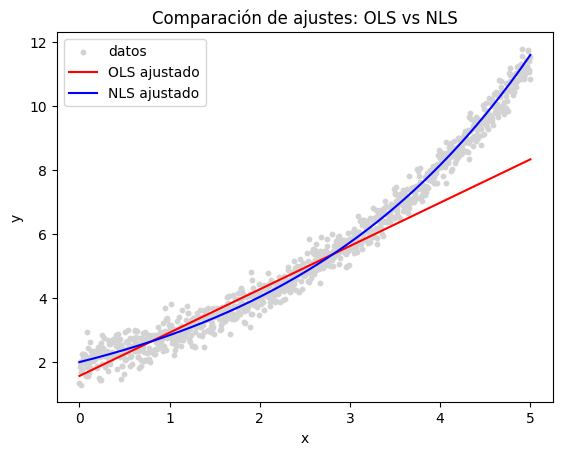

In [77]:
plt.figure()
plt.scatter(data["x"], data["y"], label="datos", color="lightgray", s=10)
plt.plot(xs, ols_full_pred, label="OLS ajustado", color="red")
plt.plot(xs, nls_full_pred, label="NLS ajustado", color="blue")
plt.xlabel("x"); plt.ylabel("y"); plt.title("Comparación de ajustes: OLS vs NLS")
plt.legend()
plt.show()

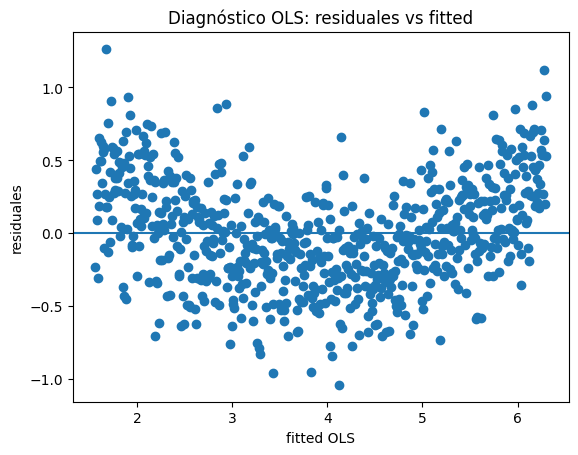

In [78]:
plt.figure()
plt.scatter(ols_tr["fitted"], train["y"].to_numpy() - ols_tr["fitted"])
plt.axhline(0)
plt.xlabel("fitted OLS"); plt.ylabel("residuales"); plt.title("Diagnóstico OLS: residuales vs fitted")
plt.show()

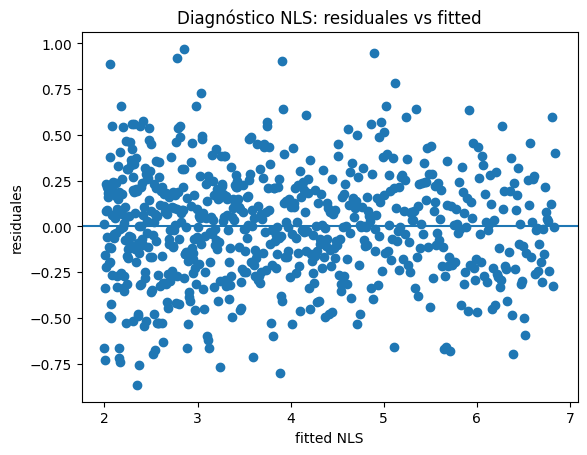

In [79]:
plt.figure()
plt.scatter(nls_tr["fitted"], train["y"].to_numpy() - nls_tr["fitted"])
plt.axhline(0)
plt.xlabel("fitted NLS"); plt.ylabel("residuales"); plt.title("Diagnóstico NLS: residuales vs fitted")
plt.show()